In [ ]:
#ignore annoying deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# K-Nearest Neighbor (KNN) Classification in Python!


## Introduction

**K-Nearest Neighbor (KNN) Classification** is a geometric classification method in which the class to which each case is assigned is based on the classes of the *k* cases in the training set that are geometrically closest to the case being classified. The class to which each case is assigned is determined by a majority vote of its neighbors, with the case being assigned to the class that is most common among its *k* nearest neighbors. The value of *k* must be a positive integer, and is typically small (e.g., 3). The output of KNN classification is thus a predicted class membership for each case being evaluated.

The images below show an example of KNN classification in a two-dimensional (i.e., two-feature) space. The stars and triangles represent the locations and classes of the **training data** in this space. At *k* = 3 the new case is assigned to Class B, while at *k* = 7 the new case is assigned to Class A. Note that the KNN method is readily extensible into higher-dimensional spaces.

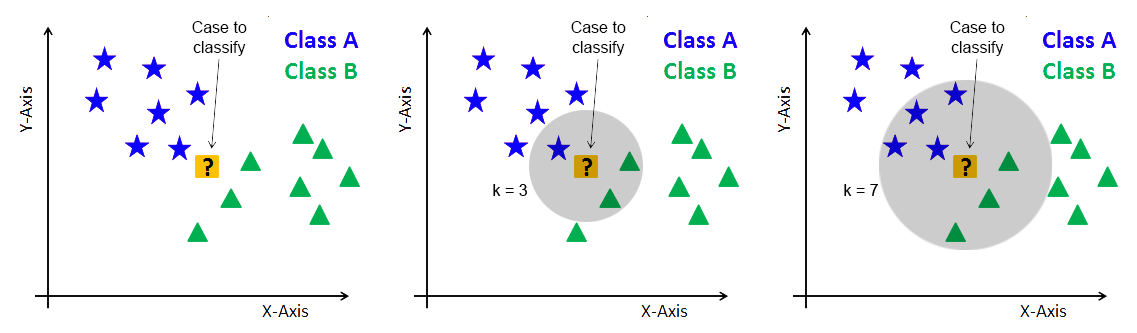

## Load Libraries and Data

In this lesson, we'll be using the *Galton Families* data that we used in a few of our previous lessons to learn how to perform a KNN classification in Python. We'll be using the `neighbors` package from **scikit-learn** to actually build our KNN classifier.

In [ ]:
#import libraries
import pandas as pd
import sklearn.neighbors as skln
import sklearn.metrics as sklm
import sklearn.model_selection as ms
from sklearn import preprocessing
import statsmodels.api as sm
import numpy as np

#get the Galton Families dataset and assign it to a pandas dataframe
df = sm.datasets.get_rdataset('GaltonFamilies', package='HistData').data

#view the first 10 rows of data in the dataframe
df.head(10)

Our goal in this lesson will be to classify each child as male or female based on the child's height and the order in which a child was born within a family. These values are recorded in the *childHeight* and *childNum* variables, respectively.

## Data Preparation

#### Recoding the 'gender' Variable
As shown in the table above, each child's gender is currently recorded using the textual labels *male* and *female*. We will need to convert these values into a binary dummy variable before proceeding with our KNN classification:

In [ ]:
#define a dictionary that specifies current and replacement values
genderCodes = {'male': 1, 'female': 0}

#use the dictionary to replace the current textual gender labels with a 0 or 1
df['gender'].replace(genderCodes, inplace=True)

#view the first 10 rows of data in the dataframe
df.head(10)

As shown above, male childern are now coded as *1*, while female children are coded as *0*.

#### Checking for Class Imbalance
Next, we'll check whether there is an approximately equal number of male and female children in the data set. If the number of children of each gender is imbalanced, then we may need to construct a balanced data set before proceeding:

In [ ]:
#show case counts for each gender
print(df.gender.value_counts())

#show the mean for the gender variable
print(df.gender.mean())

The values shown above indicate that our data set contains 481 male children and 453 female children, and that approximately 51.5% of the children are male. There are an approximately equal number of male and female children, so we can proceed with our analysis.

#### Normalizing (Rescaling) the Data
The two variables that we'll be using as the basis for our classification (*childHeight* and *childNum*) have vastly different distributions, as revealed by the descriptive statistics below:

In [ ]:
#show descriptives for the childHeight and childNum variables
df[['childHeight', 'childNum']].describe().transpose()

Since KNN classification relies on the **distance between points** in order to predict class membership, it is important to normalize (rescale) our data to ensure that the dstributional differences between our two variables do not cause one variable to have excessive influence in the KNN algorithm's distance calculations:

In [ ]:
#define a standard (z-score) scaler object
scaler = preprocessing.StandardScaler()

#perform z-score normalization on all of the numeric variables
z_score_scaled = scaler.fit_transform(df[['childHeight', 'childNum']])

#convert the numpy ndarray into a pandas dataframe
z_score_scaled = pd.DataFrame(z_score_scaled)

#name the columns in the new dataframe
z_score_scaled.columns = ['childHeight', 'childNum']

#construct a data frasme containing all three variables
df = pd.concat([df['gender'], z_score_scaled], axis=1)

#view descriptive statististics
df.describe()

Our *childHeight* and *childNum* variables have been successfully rescaled into z-scores, so we can now proceed with splitting our data.

#### Training and Testing Data
Now that we have verified that we have a balanced data set and have normalized our variables, we can proceed with subdividing our data set into training and testing sets. This step is critically important -- if a classification model is evaluated using only the data that were used to train the model, then the results will be both biased and overly optimistic for real-world scenarios.

For our purposes, we will create a training set that contains 70% of our data, while the testing set will contain the remaining 30% of the data:

In [ ]:
#define a random seed to ensure that the results are consistent
np.random.seed(1234)

#compute the size of the testing data set
test_size = int(df.shape[0] * 0.3) #30% of the data will be used for testing

#use Bernoulli sampling to get a two-dimensional array that contains the indexes of the rows that will comprise the training and testing data sets
indexes = ms.train_test_split(range(df.shape[0]), test_size = test_size)

#define the training data set
training = df.iloc[indexes[0],:]

#define the testing data set
testing = df.iloc[indexes[1],:]

Now that we've completed preparing our data, let's build our KNN classifier!

## Build the KNN Classifier
Next, we'll use our **training data** to build our KNN classification model. To build the model, we will:
1. Define a KNN classification model object using the `KNeighborsClassifier` method from the scikit-learn `neighbors` package.
2. Train the classification model using the predictor and outcome variables from our **training** data set:

In [ ]:
#define and train the KNN classifier
knn_mod = skln.KNeighborsClassifier(n_neighbors=3) 
knn_mod.fit(training[['childHeight', 'childNum']], training['gender'])

Notice that the configuration of the model object is printed during the estimation process. In our case, all of the values shown are default settings because we didn't specify any custom settings when creating the model object.

Next, let's use our trained model to get all of the class predictions for our **testing** data:

In [ ]:
#calculate class (gender) predictions for the children in the testing data set
gender_predictions = knn_mod.predict(testing[['childHeight', 'childNum']])

#show the first 10 gender predictions for the testing data
print(gender_predictions[:10])

Now that we have our gender predictions for the children in the testing data set, let's see how well our KNN classifier works:

## Evaluate the KNN Classifier
The most common way to evaluate the performance of a classifier is to use a **confusion matrix**. A confusion matrix displays the number of correctly and incorrectly classified cases in a table. We are predicting genders, so the table would look like this:

| | Predicted Male | Predicted Female|  
|------|:------:|:------:| 
|**Actual Male** | ? | ? |
|**Actual Female**| ? | ? |   

Additional performance metrice include:

**Accuracy**: Accuracy is the percentage of cases correctly predicted.

**Precision**: Precision is the number of correctly predicted cases for the label value divided by all the cases in the column.

**Recall**: Recall is the percentage of cases of a label value correctly predicted out of all cases that actually have that label value.

**F1**: The F1 statistic is weighted average of precision and recall. Put differently, F1 is a weighted metric for overall model performance.

Let's see how well our KNN classification model is able to predict whether or not a child is male or female based on the child's height and the order in which the chaild was born within a family:

In [ ]:
#define a function that prints a confusion matrix and other performance metrics
def print_metrics(actual, predicted):
    metrics = sklm.precision_recall_fscore_support(actual, predicted)
    conf = sklm.confusion_matrix(actual, predicted)
    print('                 CONFUSION MATRIX')
    print('                 Predicted male    Predicted female')
    print('Actual male      %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual female    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(actual, predicted))
    print(' ')
    print('           Male          Female')
    print('Cases      %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

#show the performance of the KNN classification model on the testing data
print_metrics(testing['gender'], gender_predictions)

As you can see, our KNN classification model is about 83% accurate overall in predicting a child's gender. We used *k* = 3 when training our model -- could we improve the accuracy by adjusting this parameter?